<a href="https://colab.research.google.com/github/AbdusSattar2025/Assignments/blob/main/CIC_2nd_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit
!pip install pyscf
# The previous installation of sklearn-extra failed, so I will remove it for now
# !pip install sklearn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 MB 10.9 MB/s eta 0:00:00


Index(['mol_id', 'smiles_canonical', 'A', 'B', 'C', 'mu', 'alpha', 'homo',
       'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv'],
      dtype='object')
Loaded dataset with 133885 rows.
Descriptors calculated and scaled. Shape: (10000, 9)
K-Means (K=2) Silhouette = 0.2398
K-Means (K=3) Silhouette = 0.2610
K-Means (K=4) Silhouette = 0.1961
DBSCAN Silhouette = 0.4687

=== FINAL SUMMARY ===
Algorithm   K  Silhouette  Eps  MinPts
  K-Means 2.0    0.239810  NaN     NaN
  K-Means 3.0    0.260981  NaN     NaN
  K-Means 4.0    0.196124  NaN     NaN
   DBSCAN NaN    0.468697  0.5    19.0


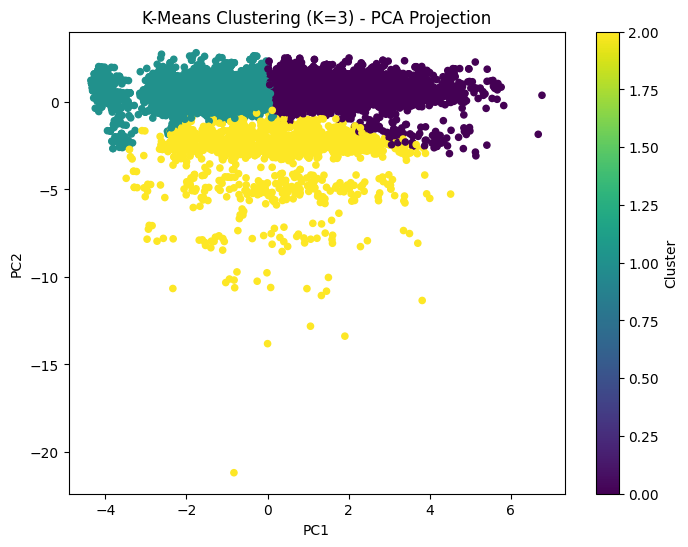

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, PandasTools
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
from sklearn.decomposition import PCA


# Load the dataset from the provided file path
df = pd.read_csv('/content/qm9_processed.csv')

# Check the column names of the dataset
print(df.columns)
smiles = df['smiles_canonical']  # Adjust based on actual column name


# Step 2: Extract SMILES column
smiles = df['smiles_canonical']

# Step 3: List of descriptors to extract
descriptor_list = [
    'MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotableBonds', 'MolMR',
    'HeavyAtomCount', 'RingCount'
]


SAMPLE_SIZE = 10000  # subset for speed
FILE_PATH = '/content/qm9_processed.csv'
SMILES_COL = 'smiles_canonical'
DESC_LIST = descriptor_list


def get_descriptors(smiles_list):
    """Extract RDKit descriptors from SMILES strings."""
    desc = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            # Use rdMolDescriptors.CalcNumRotatableBonds for NumRotableBonds
            d_values = []
            for d in DESC_LIST:
                if d == 'NumRotableBonds':
                    d_values.append(rdMolDescriptors.CalcNumRotatableBonds(mol))
                else:
                    d_values.append(getattr(Descriptors, d)(mol))
            desc.append(d_values)
        else:
            desc.append([np.nan]*len(DESC_LIST))
    return pd.DataFrame(desc, columns=DESC_LIST)

# ======= LOAD & PREPARE DATA =======
df = pd.read_csv(FILE_PATH)
print(f"Loaded dataset with {len(df)} rows.")

desc_df = get_descriptors(df[SMILES_COL])
data = desc_df.dropna()
df = df.loc[data.index].reset_index(drop=True)  # keep SMILES aligned
data = data.reset_index(drop=True)

if len(data) > SAMPLE_SIZE:
    data = data.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    df = df.loc[data.index].reset_index(drop=True)

# ======= SCALE FEATURES =======
X_scaled = StandardScaler().fit_transform(data)
print(f"Descriptors calculated and scaled. Shape: {X_scaled.shape}")

# ======= K-MEANS CLUSTERING =======
summary = []
for k in [2, 3, 4]:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = model.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    summary.append({'Algorithm': 'K-Means', 'K': k, 'Silhouette': sil})
    print(f"K-Means (K={k}) Silhouette = {sil:.4f}")

# ======= DBSCAN CLUSTERING =======
eps, min_pts = 0.5, 19
db = DBSCAN(eps=eps, min_samples=min_pts)
labels_db = db.fit_predict(X_scaled)

if len(set(labels_db)) > 1:
    mask = labels_db != -1
    sil = silhouette_score(X_scaled[mask], labels_db[mask])
    summary.append({'Algorithm': 'DBSCAN', 'Eps': eps, 'MinPts': min_pts, 'Silhouette': sil})
    print(f"DBSCAN Silhouette = {sil:.4f}")
else:
    print("DBSCAN found no valid clusters.")

# ======= SUMMARY TABLE =======
summary_df = pd.DataFrame(summary)
print("\n=== FINAL SUMMARY ===")
print(summary_df.to_string(index=False))

# ======= VISUALIZATION USING PCA =======
best_k = 3  # choose K with best silhouette for visualization
kmeans_labels = KMeans(n_clusters=best_k, random_state=42, n_init='auto').fit_predict(X_scaled)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pcs[:,0], pcs[:,1], c=kmeans_labels, cmap='viridis', s=20)
plt.title(f'K-Means Clustering (K={best_k}) - PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
data['agg_label'] = agg_labels
display(data.head())

,MolWt,MolLogP,NumHDonors,NumHAcceptors,TPSA,NumRotableBonds,MolMR,HeavyAtomCount,RingCount,kmeans_label,dbscan_label,agg_label
0,95.101,0.29888,0,2,33.02,0,22.4030,7,2,2,-1,1
1,128.127,-0.80400,1,3,46.53,2,31.7228,9,0,0,-1,0
2,127.143,0.48130,1,3,41.82,1,31.6155,9,2,0,-1,0
3,126.155,0.61370,0,2,26.30,4,34.9280,9,0,1,-1,0
4,127.147,0.25054,2,3,60.17,0,33.7854,9,1,0,-1,2


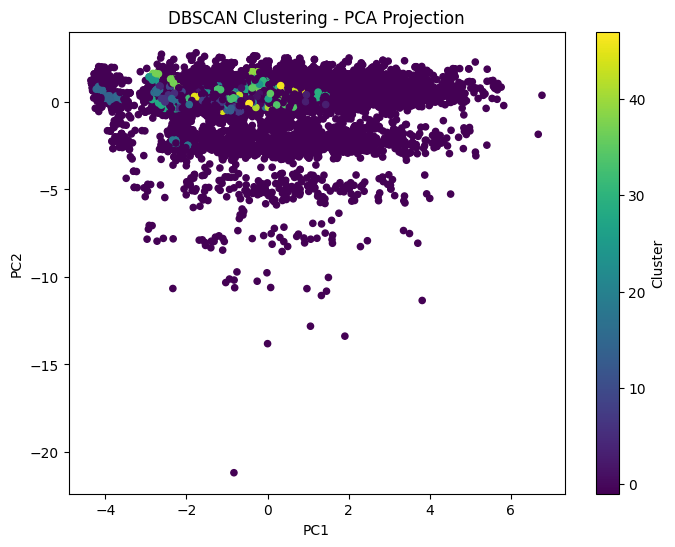

In [ ]:
plt.figure(figsize=(8,6))
# Exclude noise points (-1 label) for silhouette score visualization if desired, but for general visualization, include them
scatter = plt.scatter(pcs[:,0], pcs[:,1], c=labels_db, cmap='viridis', s=20)
plt.title('DBSCAN Clustering - PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
# Add a colorbar to show the cluster labels
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
plt.show()

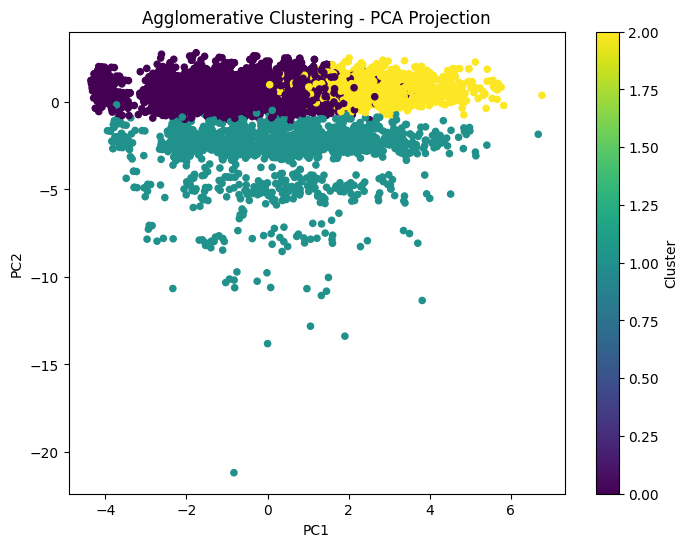

In [ ]:
# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3) # Using 3 clusters for consistency with best_k from K-Means
agg_labels = agg_clustering.fit_predict(X_scaled)

# Visualize Agglomerative Clustering results using PCA
plt.figure(figsize=(8,6))
scatter_agg = plt.scatter(pcs[:,0], pcs[:,1], c=agg_labels, cmap='viridis', s=20)
plt.title('Agglomerative Clustering - PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter_agg, label='Cluster')
plt.show()

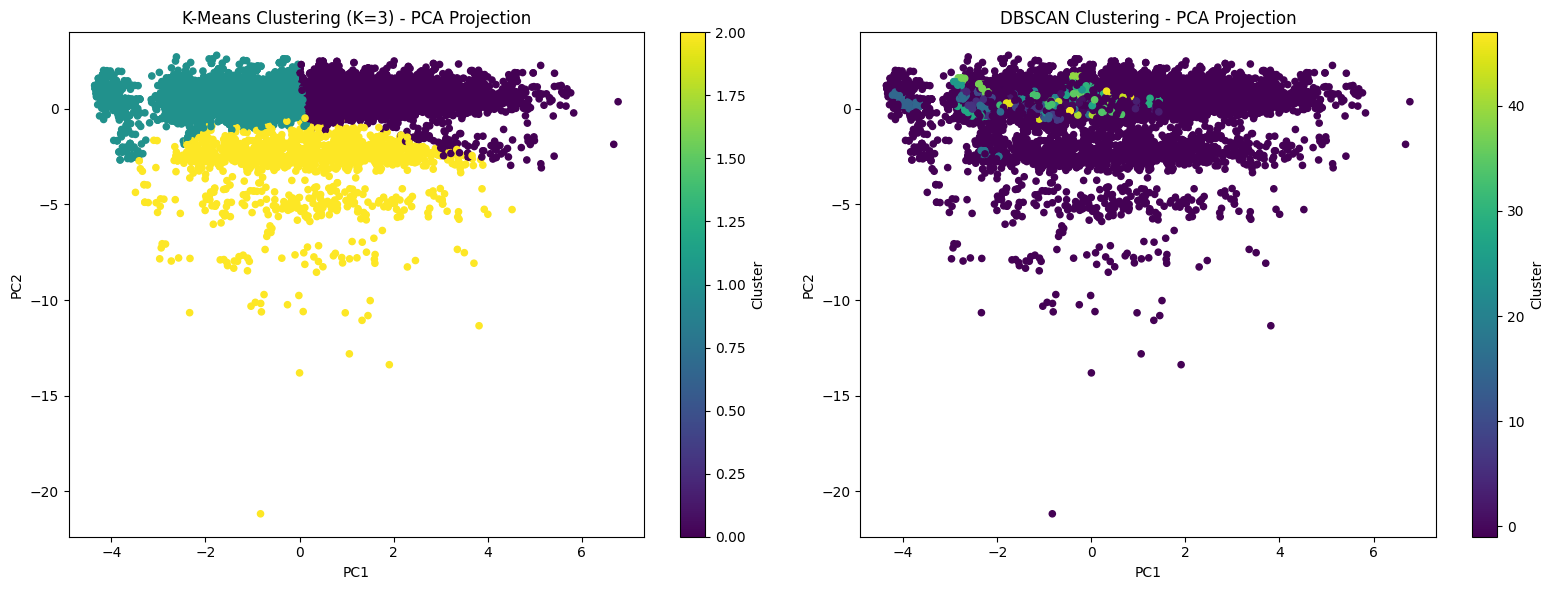

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means Visualization
scatter_kmeans = axes[0].scatter(pcs[:,0], pcs[:,1], c=kmeans_labels, cmap='viridis', s=20)
axes[0].set_title(f'K-Means Clustering (K={best_k}) - PCA Projection')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
fig.colorbar(scatter_kmeans, ax=axes[0], label='Cluster')

# DBSCAN Visualization
scatter_dbscan = axes[1].scatter(pcs[:,0], pcs[:,1], c=labels_db, cmap='viridis', s=20)
axes[1].set_title('DBSCAN Clustering - PCA Projection')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
fig.colorbar(scatter_dbscan, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

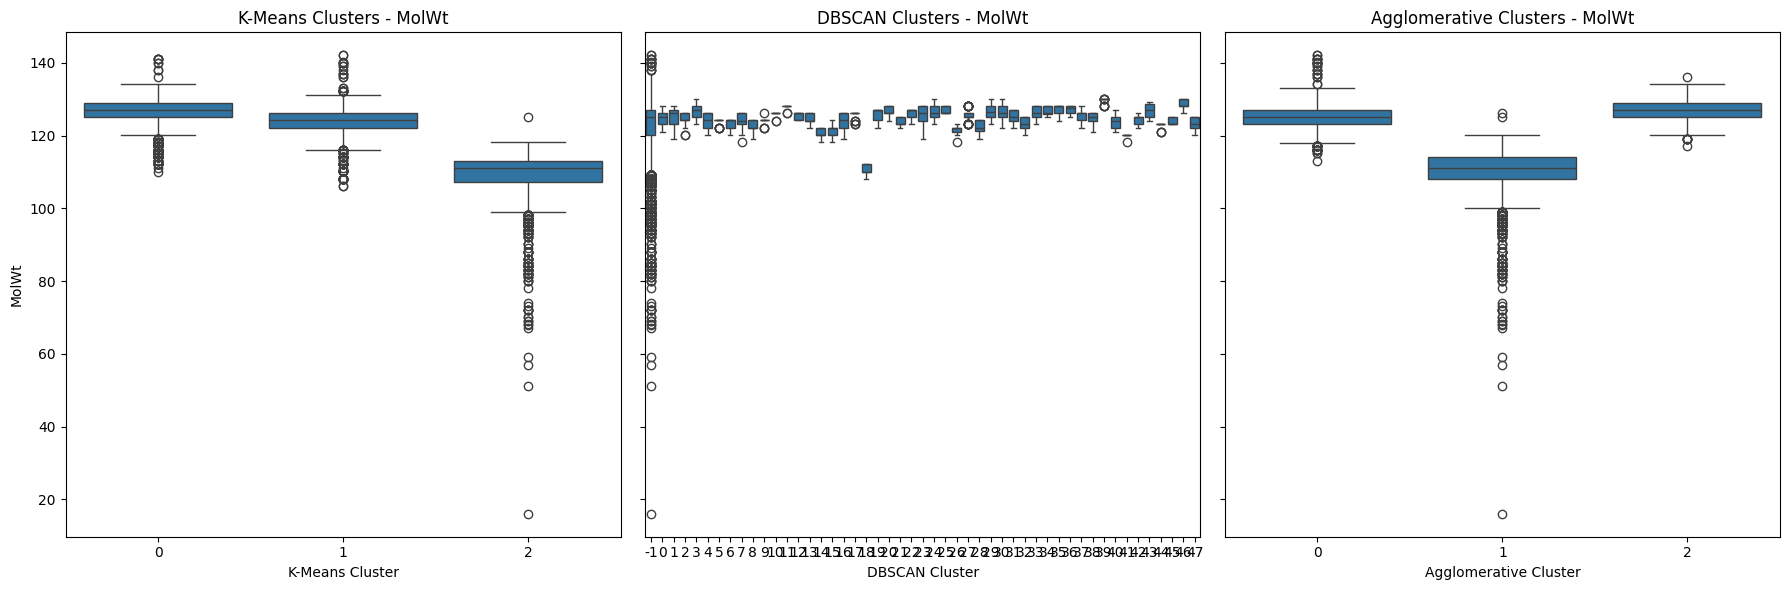

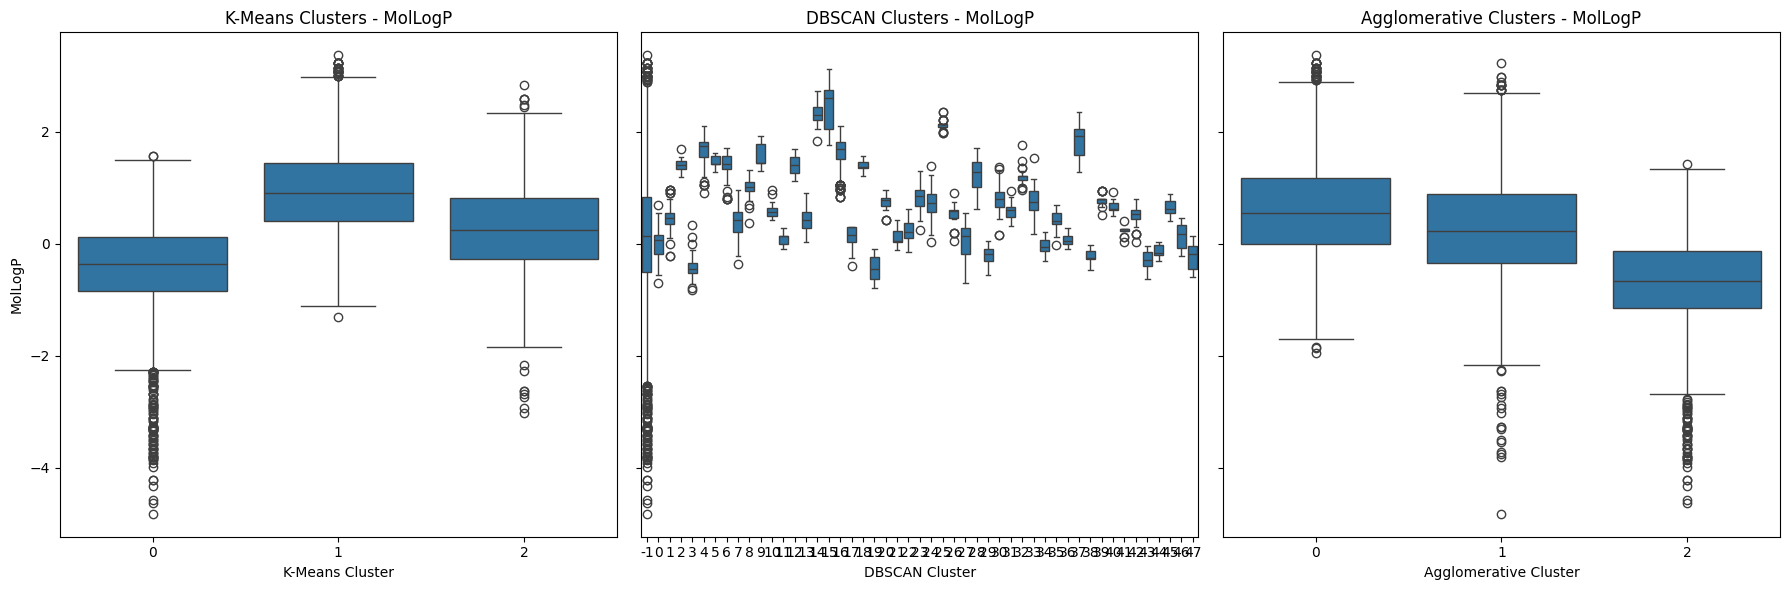

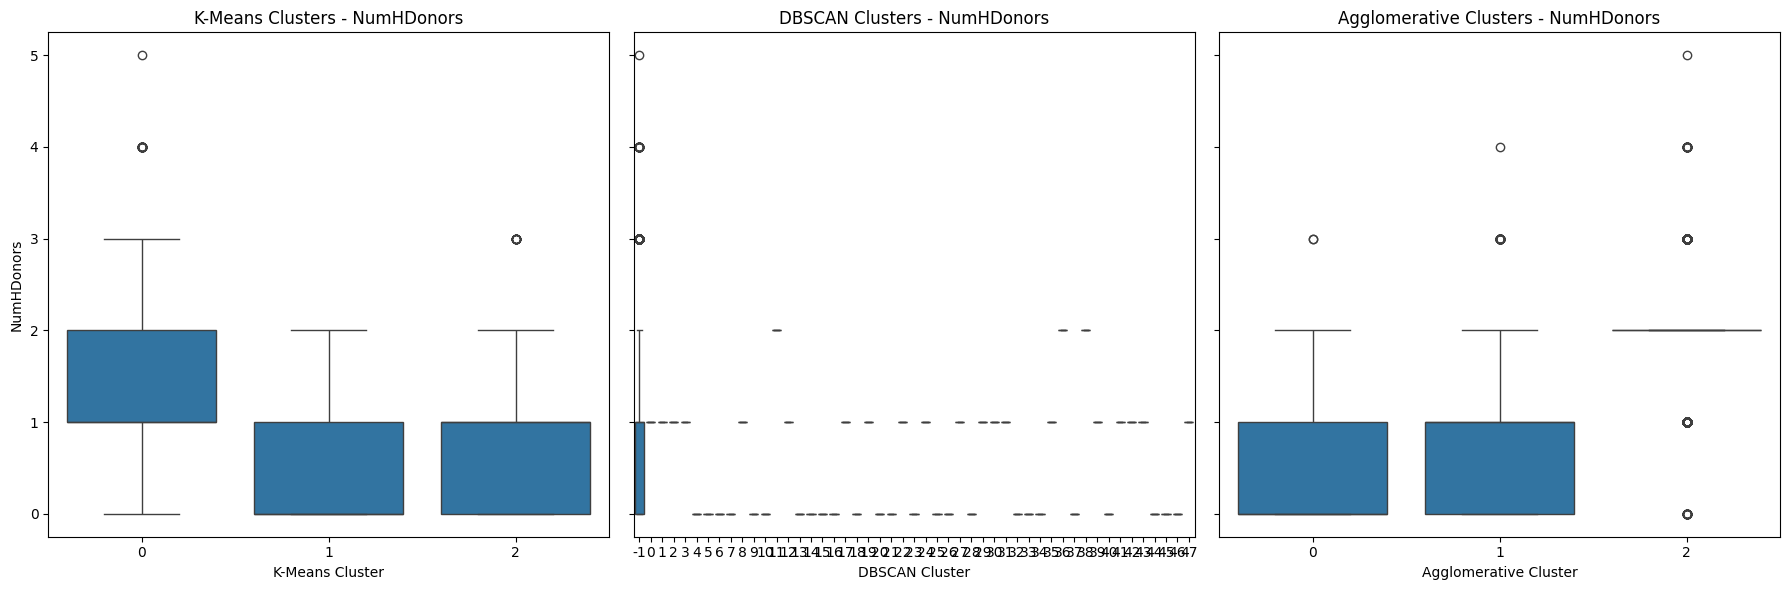

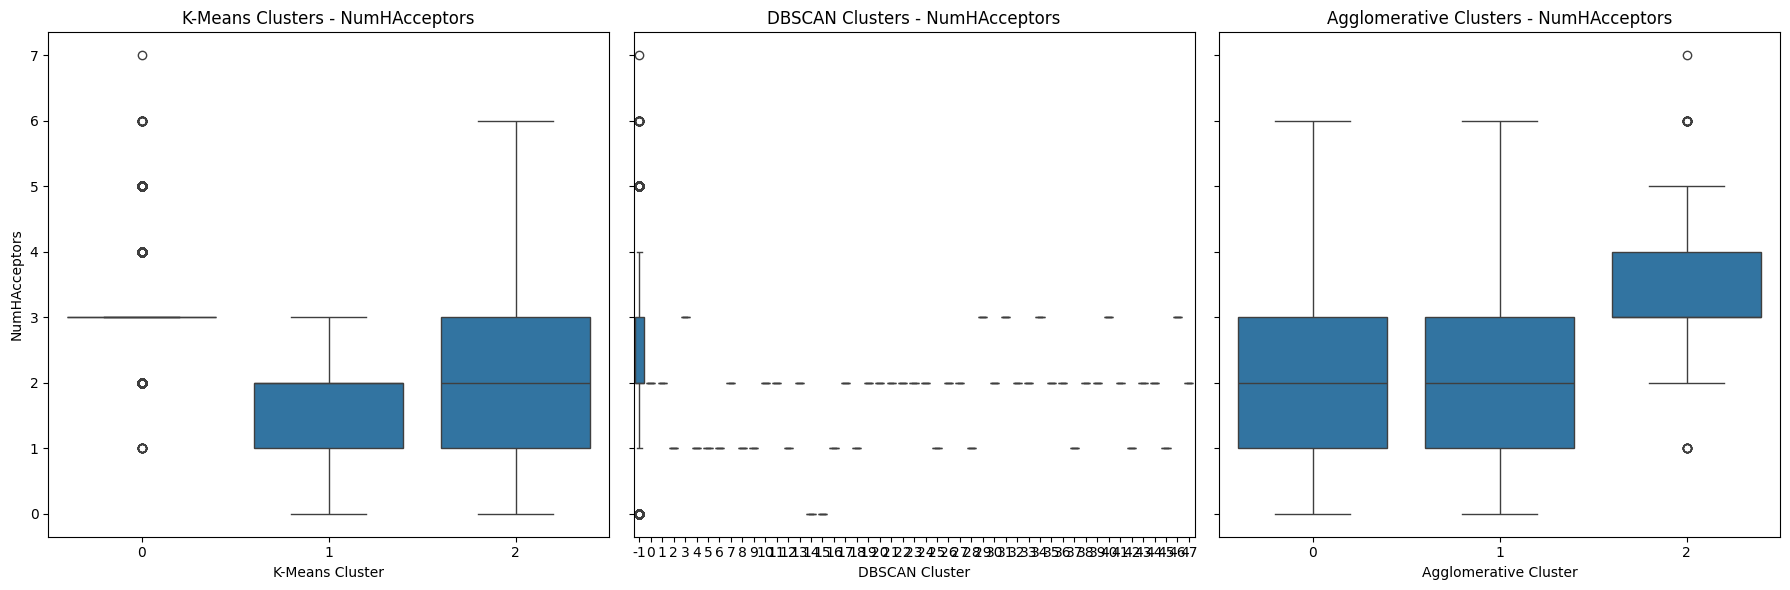

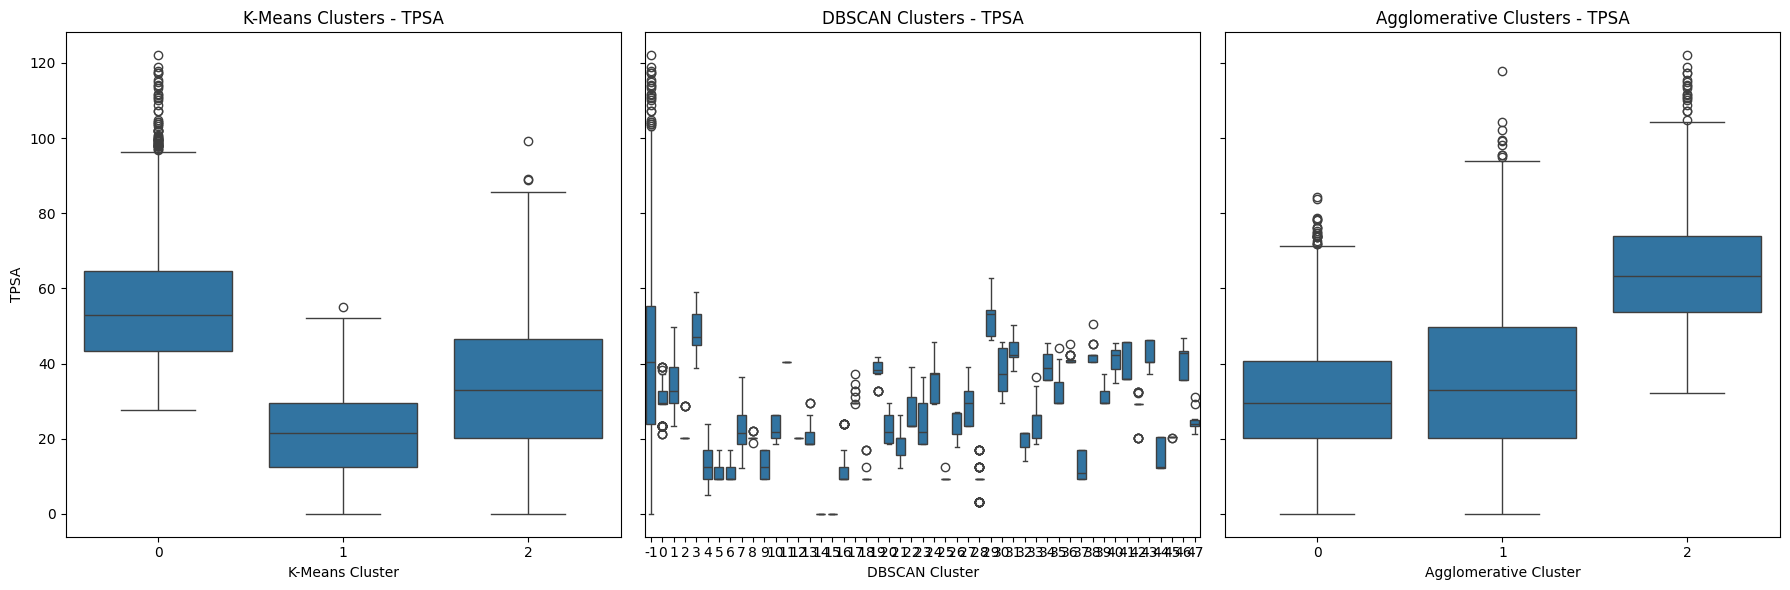

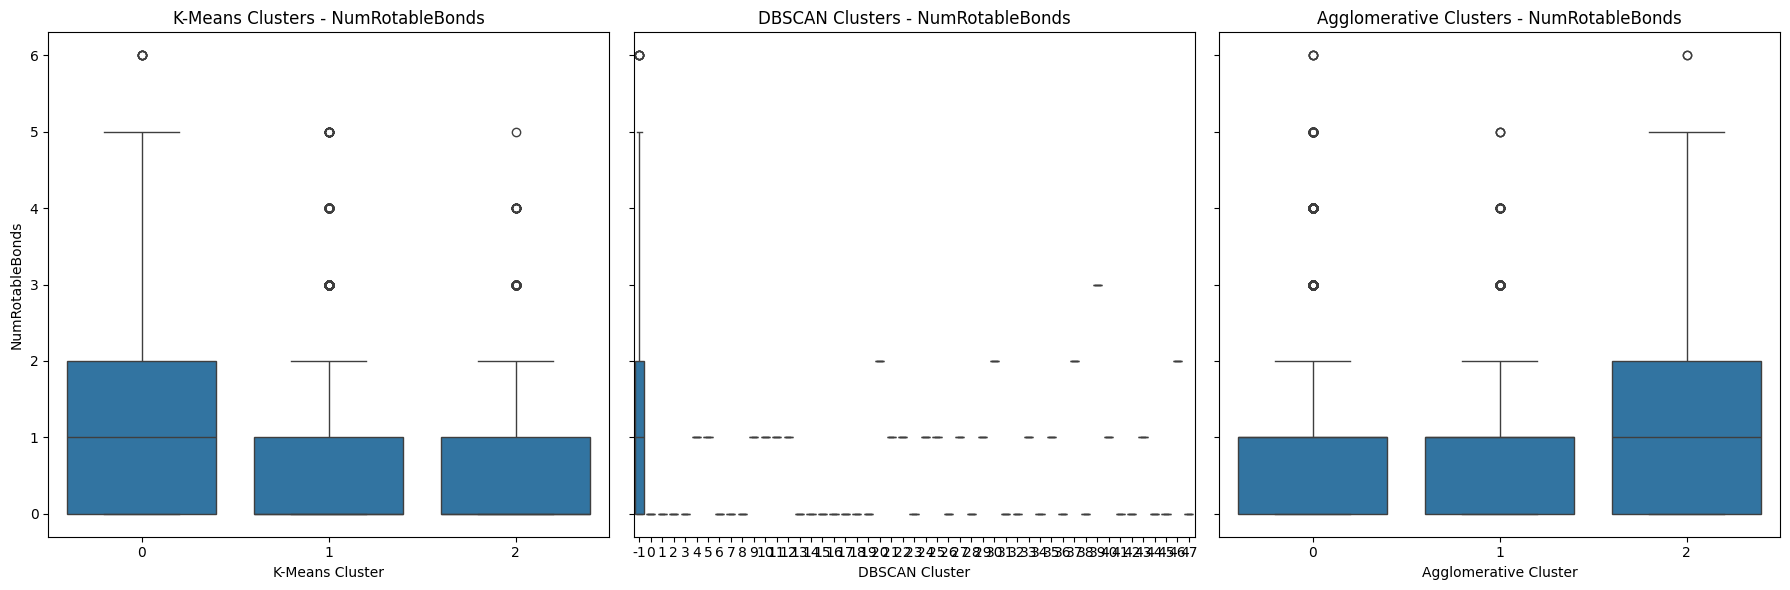

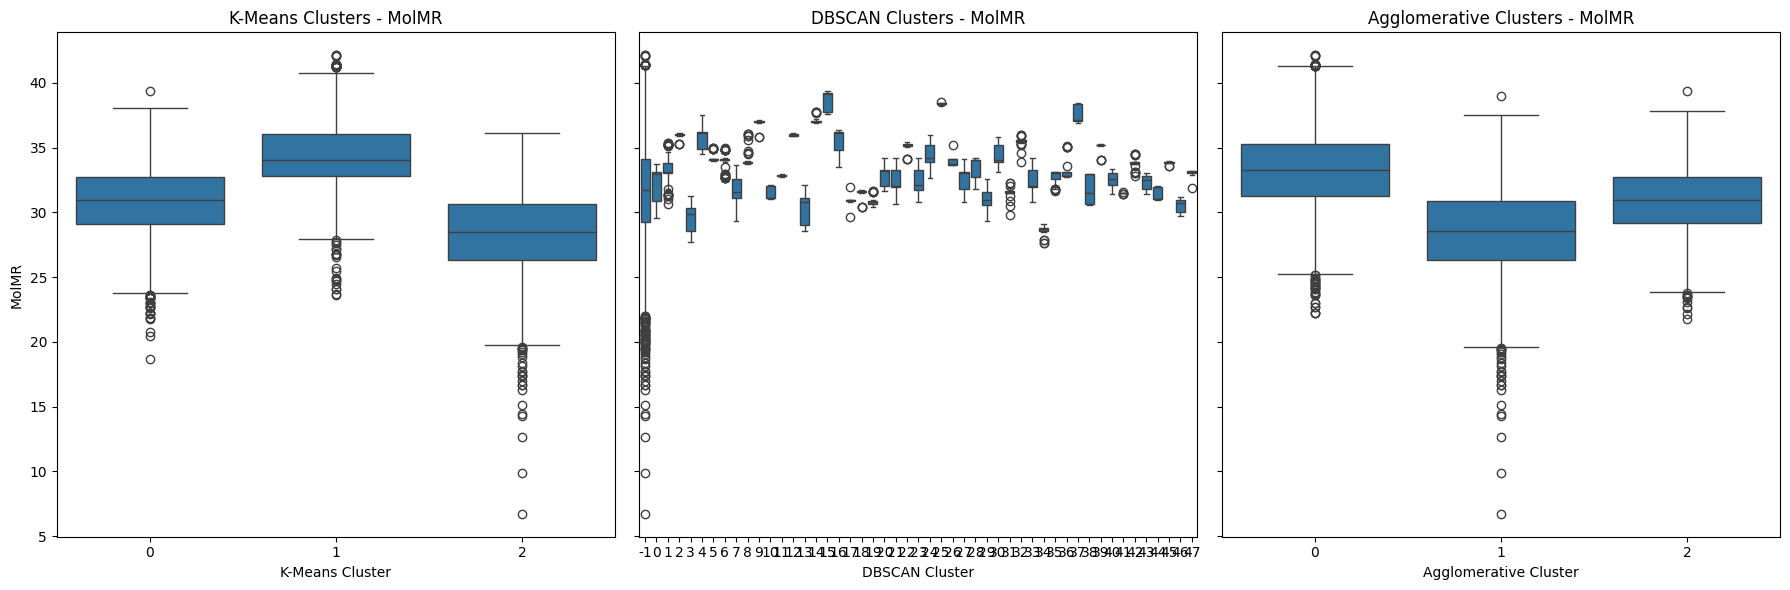

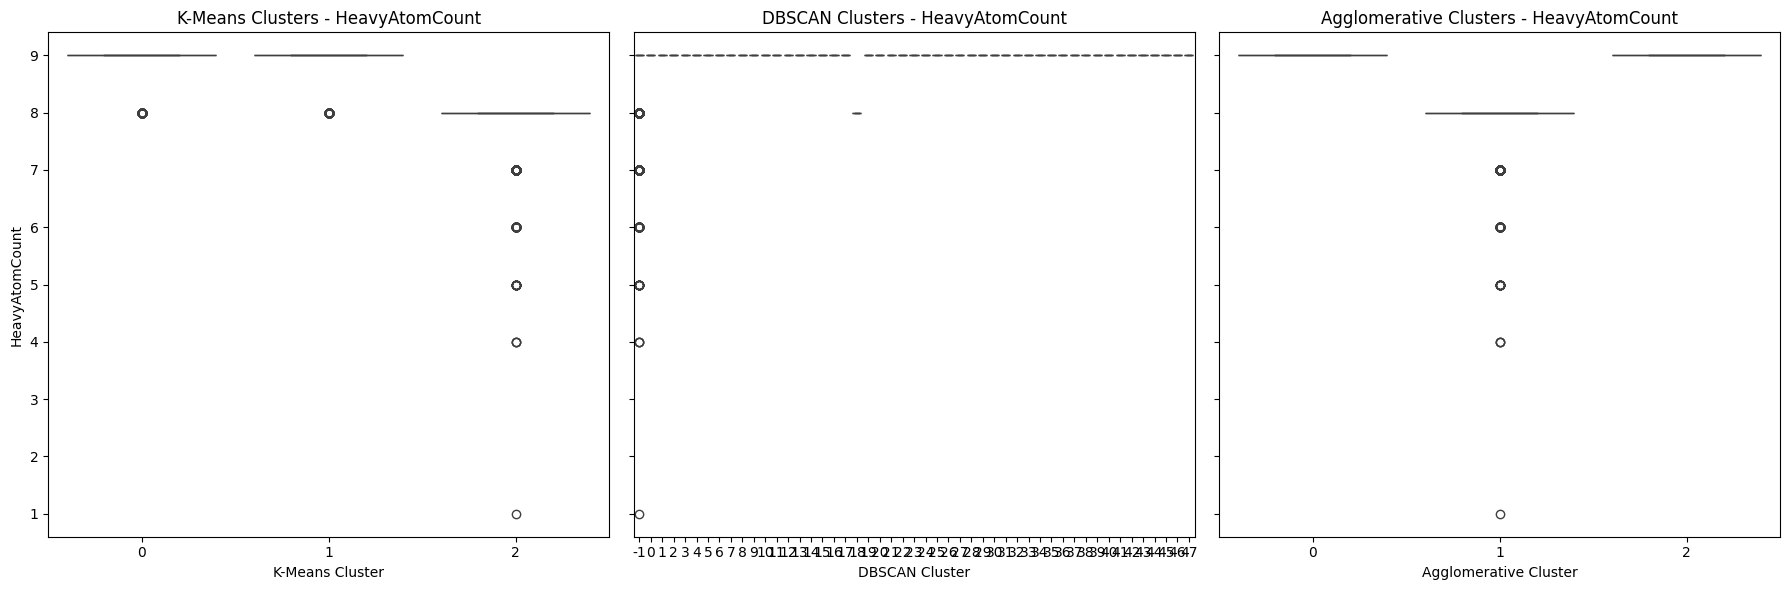

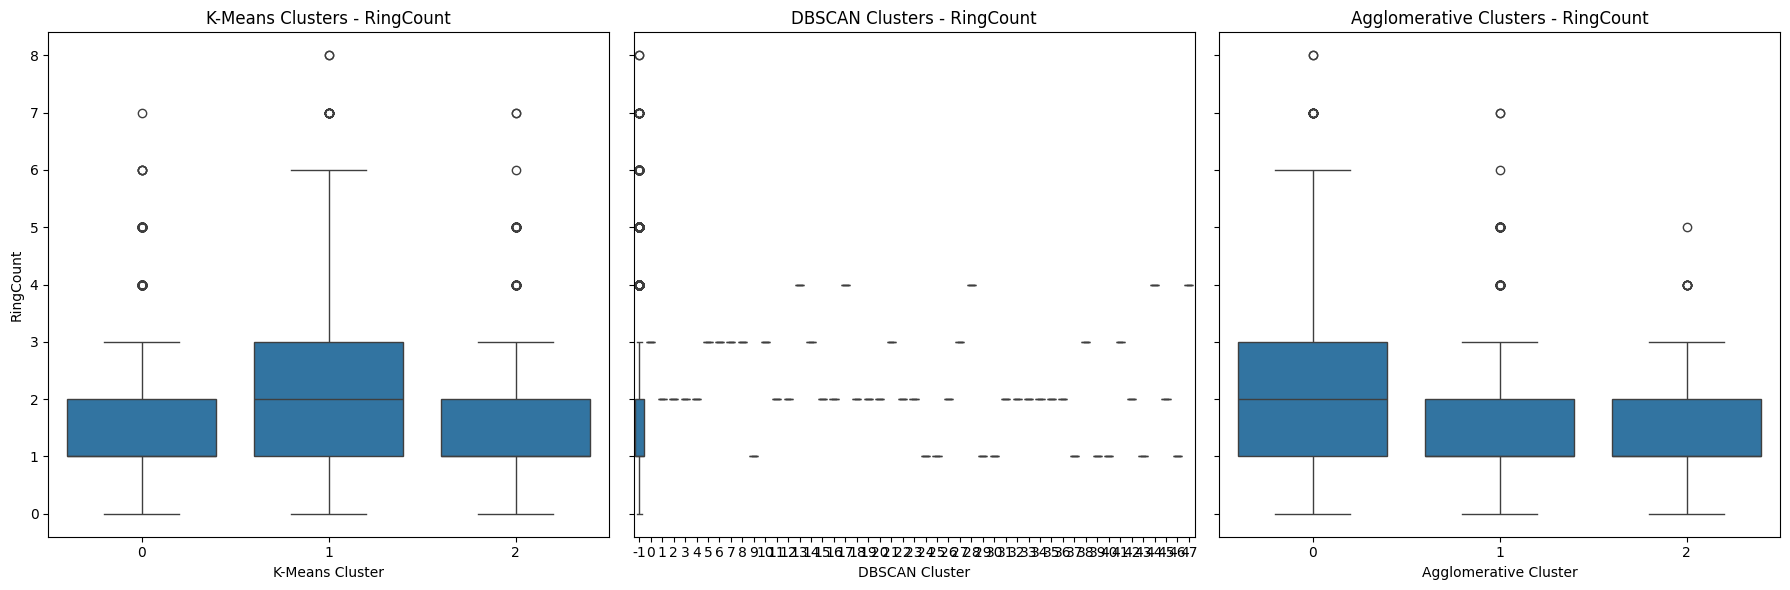

In [ ]:
for descriptor in DESC_LIST:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # K-Means
    sns.boxplot(x='kmeans_label', y=descriptor, data=data, ax=axes[0])
    axes[0].set_title(f'K-Means Clusters - {descriptor}')
    axes[0].set_xlabel('K-Means Cluster')
    axes[0].set_ylabel(descriptor)

    # DBSCAN
    sns.boxplot(x='dbscan_label', y=descriptor, data=data, ax=axes[1])
    axes[1].set_title(f'DBSCAN Clusters - {descriptor}')
    axes[1].set_xlabel('DBSCAN Cluster')
    axes[1].set_ylabel('') # Remove y-label for clarity

    # Agglomerative Clustering
    sns.boxplot(x='agg_label', y=descriptor, data=data, ax=axes[2])
    axes[2].set_title(f'Agglomerative Clusters - {descriptor}')
    axes[2].set_xlabel('Agglomerative Cluster')
    axes[2].set_ylabel('') # Remove y-label for clarity

    plt.tight_layout()
    plt.show()

# Task
Compare descriptor distributions between K-Means and DBSCAN clusters.

## Combine data and cluster labels

### Subtask:
Add the K-Means and DBSCAN cluster labels to the DataFrame containing the molecular descriptors.


In [ ]:
data['kmeans_label'] = kmeans_labels
data['dbscan_label'] = labels_db
display(data.head())

,MolWt,MolLogP,NumHDonors,NumHAcceptors,TPSA,NumRotableBonds,MolMR,HeavyAtomCount,RingCount,kmeans_label,dbscan_label
0,95.101,0.29888,0,2,33.02,0,22.4030,7,2,2,-1
1,128.127,-0.80400,1,3,46.53,2,31.7228,9,0,0,-1
2,127.143,0.48130,1,3,41.82,1,31.6155,9,2,0,-1
3,126.155,0.61370,0,2,26.30,4,34.9280,9,0,1,-1
4,127.147,0.25054,2,3,60.17,0,33.7854,9,1,0,-1


## Visualize descriptor distributions for k-means

### Subtask:
Generate plots (e.g., box plots or violin plots) for each descriptor, showing the distribution across the K-Means clusters.


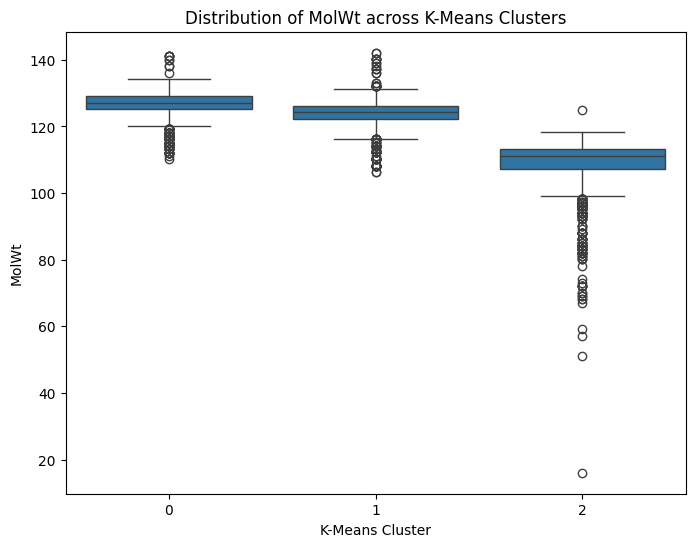

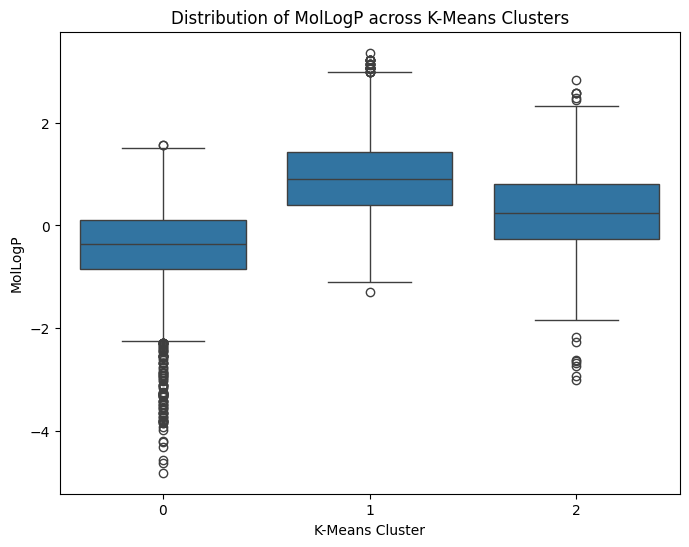

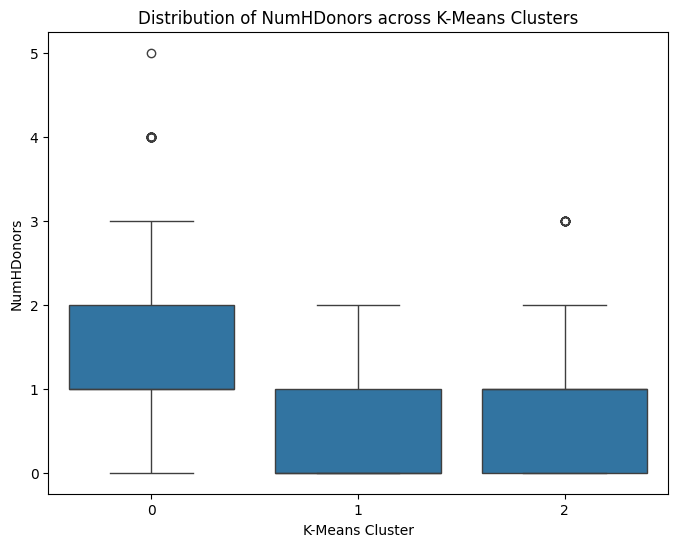

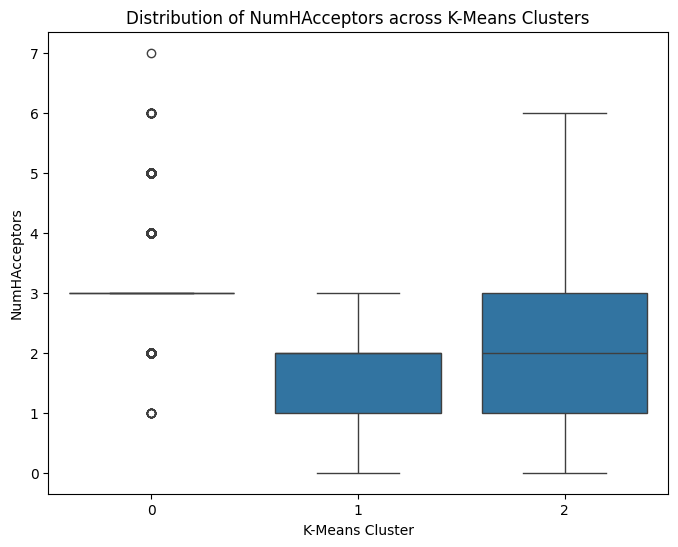

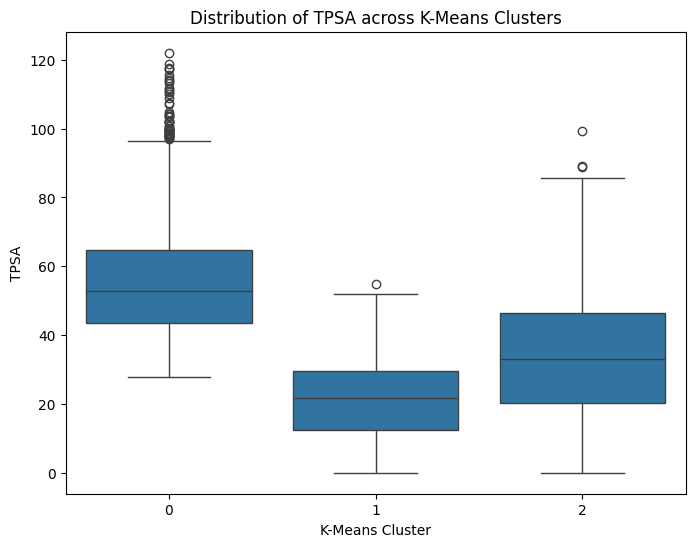

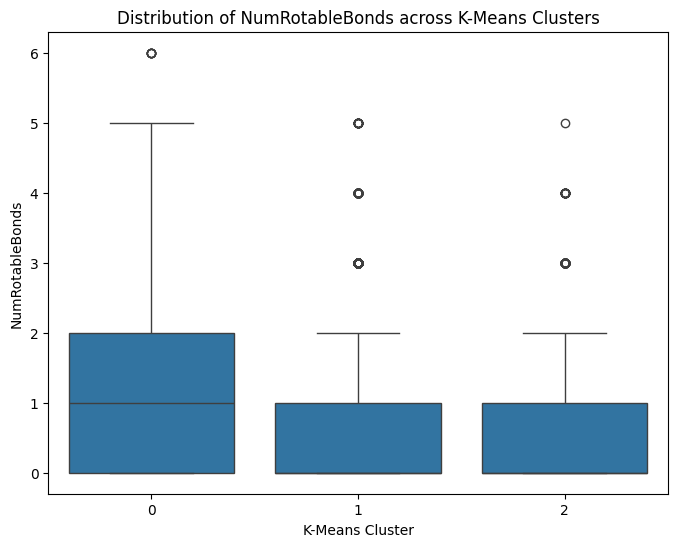

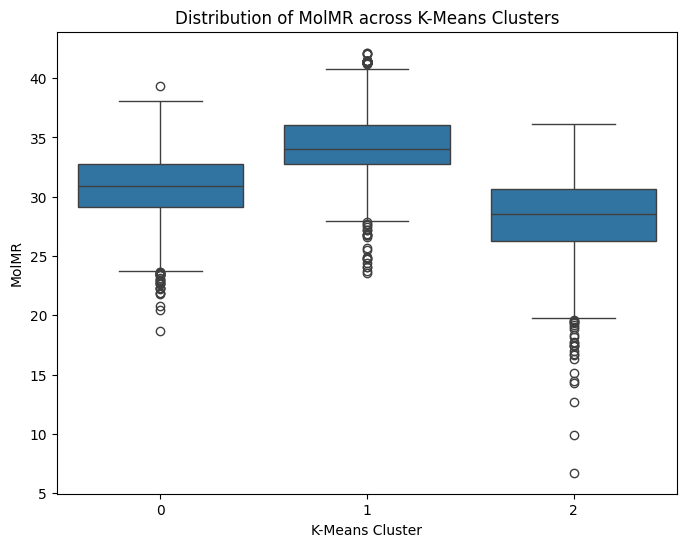

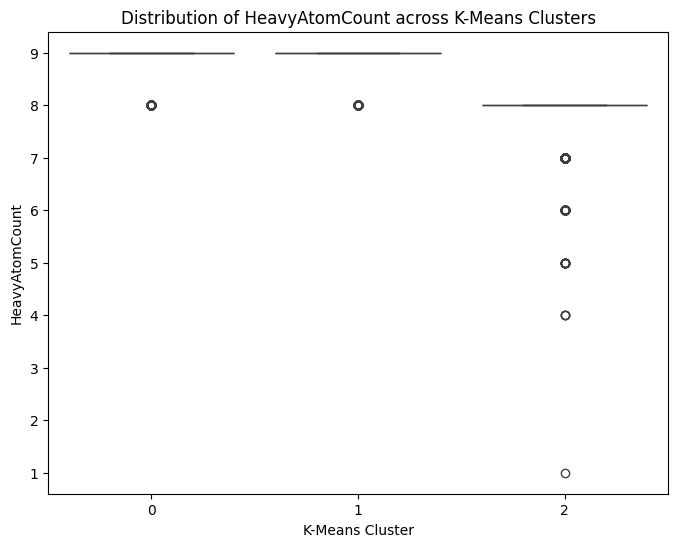

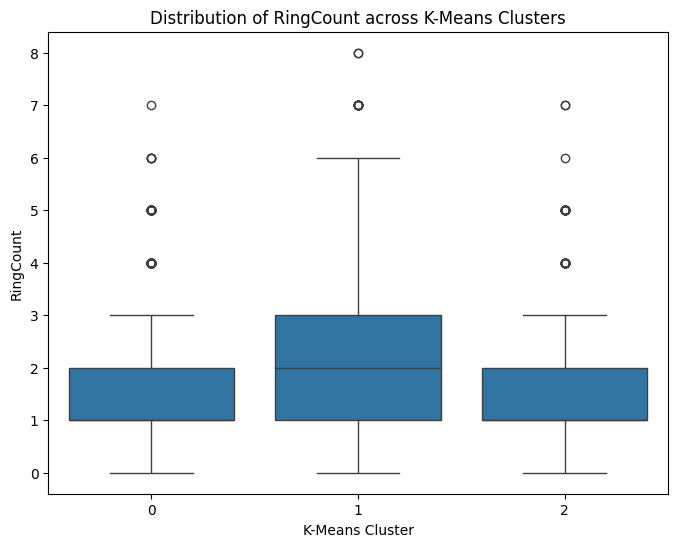

In [ ]:
for descriptor in DESC_LIST:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='kmeans_label', y=descriptor, data=data)
    plt.title(f'Distribution of {descriptor} across K-Means Clusters')
    plt.xlabel('K-Means Cluster')
    plt.ylabel(descriptor)
    plt.show()

# Task
Refine DBSCAN parameters to potentially find more clusters.

## Define parameter grid

### Subtask:
Specify a range of `eps` and `min_samples` values to explore for refining DBSCAN parameters.


In [ ]:
# Specify ranges for eps and min_samples
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values = [10, 15, 19, 25, 30]

print("eps_values:", eps_values)
print("min_samples_values:", min_samples_values)

eps_values: [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values: [10, 15, 19, 25, 30]


## Iterate and cluster

### Subtask:
Loop through the parameter combinations defined in the previous step, run DBSCAN for each combination, and store the results (number of clusters, silhouette score) in a list.


In [ ]:
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels_db = db.fit_predict(X_scaled)

        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)

        sil_score = 'N/A'
        if n_clusters >= 2:
            mask = labels_db != -1
            sil_score = silhouette_score(X_scaled[mask], labels_db[mask])

        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'silhouette_score': sil_score
        })
        print(f"DBSCAN with eps={eps}, min_samples={min_samples}: found {n_clusters} clusters (Silhouette: {sil_score})")


DBSCAN with eps=0.3, min_samples=10: found 119 clusters (Silhouette: 0.6912824045274549)
DBSCAN with eps=0.3, min_samples=15: found 50 clusters (Silhouette: 0.7016010718594956)
DBSCAN with eps=0.3, min_samples=19: found 33 clusters (Silhouette: 0.7060954718556618)
DBSCAN with eps=0.3, min_samples=25: found 17 clusters (Silhouette: 0.7605823211540618)
DBSCAN with eps=0.3, min_samples=30: found 14 clusters (Silhouette: 0.7699731338843744)
DBSCAN with eps=0.4, min_samples=10: found 133 clusters (Silhouette: 0.5563870330301651)
DBSCAN with eps=0.4, min_samples=15: found 66 clusters (Silhouette: 0.5863563444476582)
DBSCAN with eps=0.4, min_samples=19: found 37 clusters (Silhouette: 0.6219945569605083)
DBSCAN with eps=0.4, min_samples=25: found 24 clusters (Silhouette: 0.6404325711240376)
DBSCAN with eps=0.4, min_samples=30: found 19 clusters (Silhouette: 0.6405740051583303)
DBSCAN with eps=0.5, min_samples=10: found 126 clusters (Silhouette: 0.40254211708802107)
DBSCAN with eps=0.5, min_sam

## Visualize promising results

### Subtask:
Select a few promising parameter sets and visualize the resulting clusters using PCA.


,eps,min_samples,n_clusters,silhouette_score
4,0.3,30,14,0.769973
3,0.3,25,17,0.760582
2,0.3,19,33,0.706095
1,0.3,15,50,0.701601
0,0.3,10,119,0.691282
9,0.4,30,19,0.640574
8,0.4,25,24,0.640433
7,0.4,19,37,0.621995
6,0.4,15,66,0.586356
5,0.4,10,133,0.556387



Promising DBSCAN Parameter Combinations:


,eps,min_samples,n_clusters,silhouette_score
4,0.3,30,14,0.769973
3,0.3,25,17,0.760582
2,0.3,19,33,0.706095
1,0.3,15,50,0.701601
0,0.3,10,119,0.691282


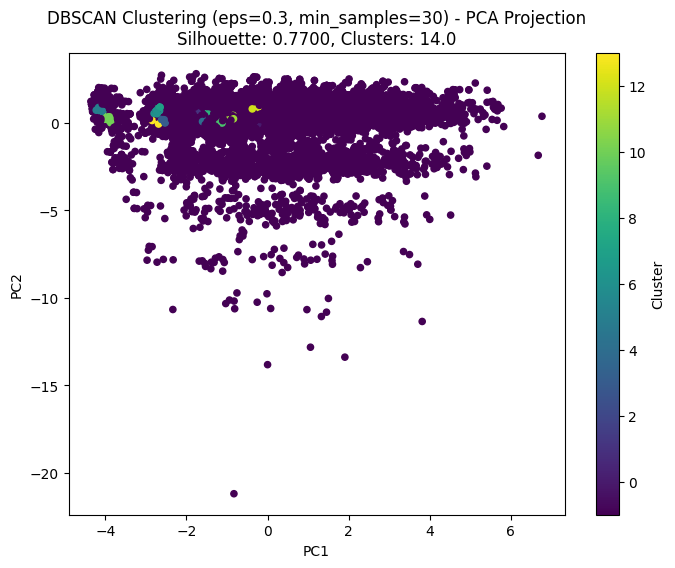

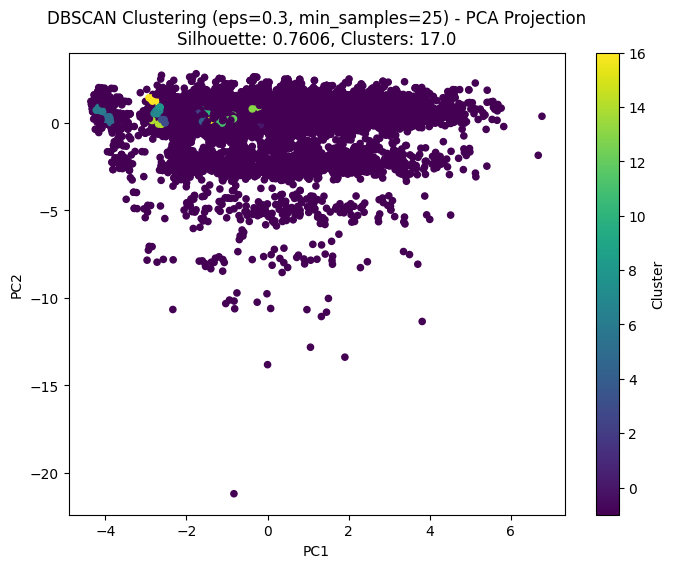

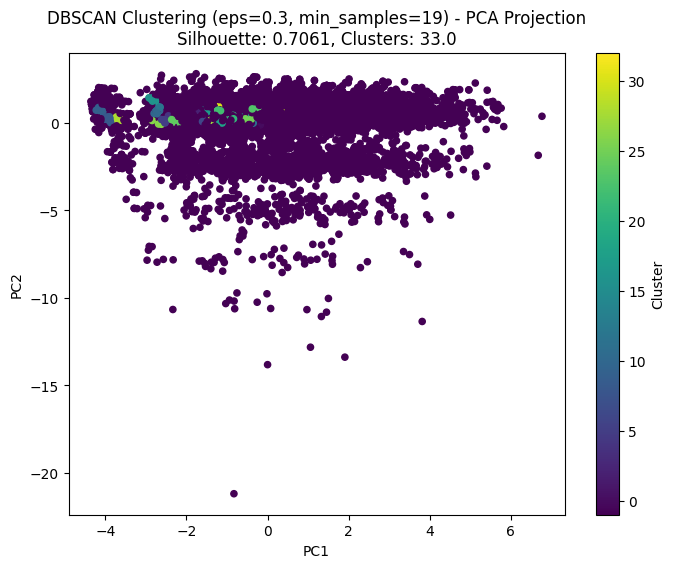

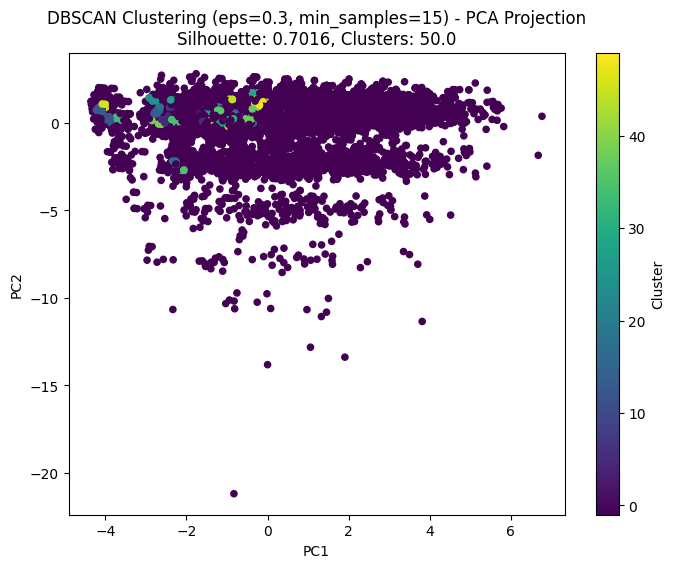

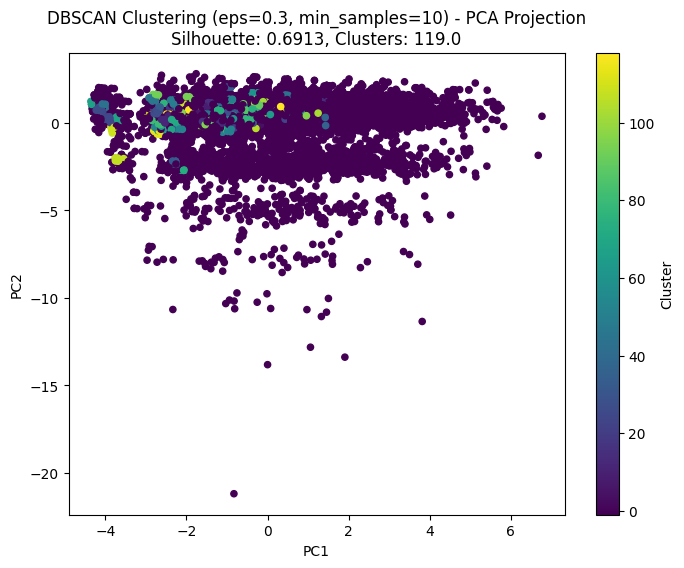

In [ ]:
# Sort the results by silhouette score in descending order
dbscan_results_df_sorted = dbscan_results_df.sort_values(by='silhouette_score', ascending=False)
display(dbscan_results_df_sorted)

# Select a few promising parameter combinations (balancing silhouette and number of clusters)
# Let's select the top 5 with silhouette score not 'N/A'
promising_params = dbscan_results_df_sorted[dbscan_results_df_sorted['silhouette_score'] != 'N/A'].head(5)
print("\nPromising DBSCAN Parameter Combinations:")
display(promising_params)

# Visualize the results for each promising parameter set
for index, row in promising_params.iterrows():
    eps = row['eps']
    min_samples = int(row['min_samples']) # Convert to integer
    n_clusters = row['n_clusters']
    sil_score = row['silhouette_score']

    # Run DBSCAN with selected parameters
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels_db = db.fit_predict(X_scaled)

    # Visualize DBSCAN Clustering results using PCA
    plt.figure(figsize=(8,6))
    scatter_db = plt.scatter(pcs[:,0], pcs[:,1], c=labels_db, cmap='viridis', s=20)
    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples}) - PCA Projection\nSilhouette: {sil_score:.4f}, Clusters: {n_clusters}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter_db, label='Cluster')
    plt.show()

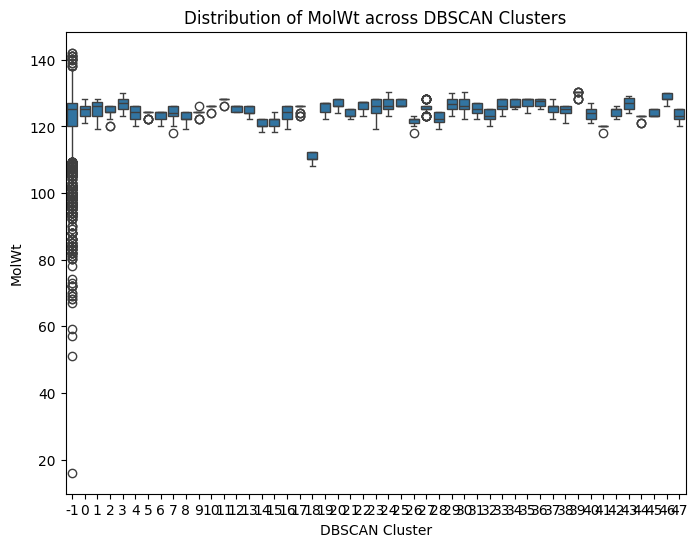

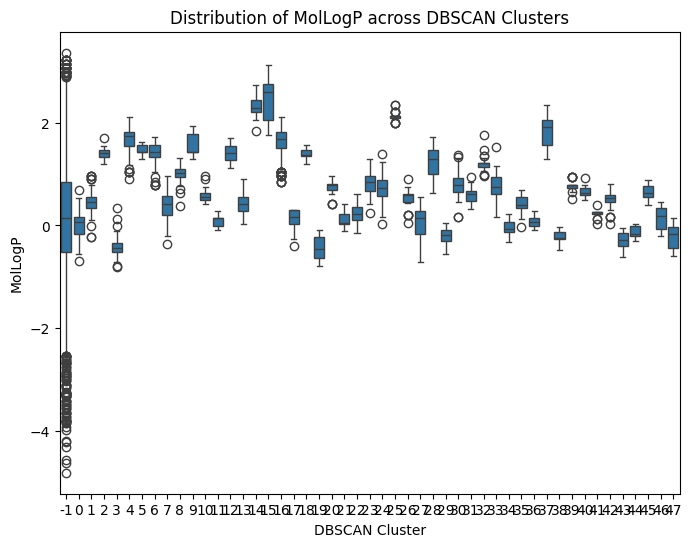

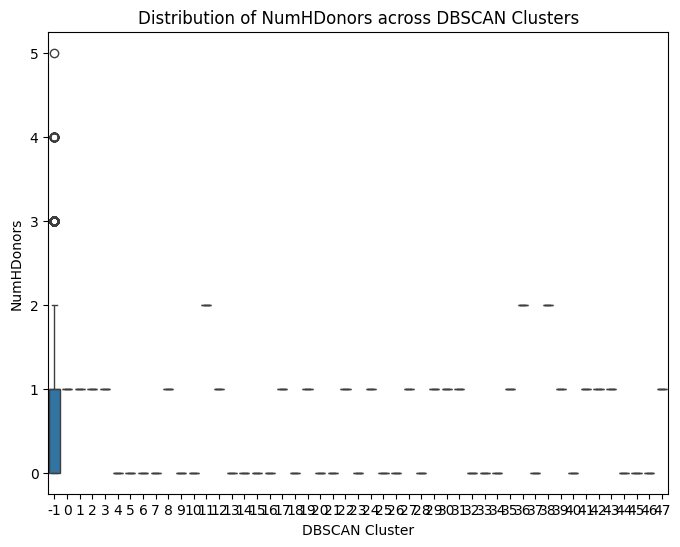

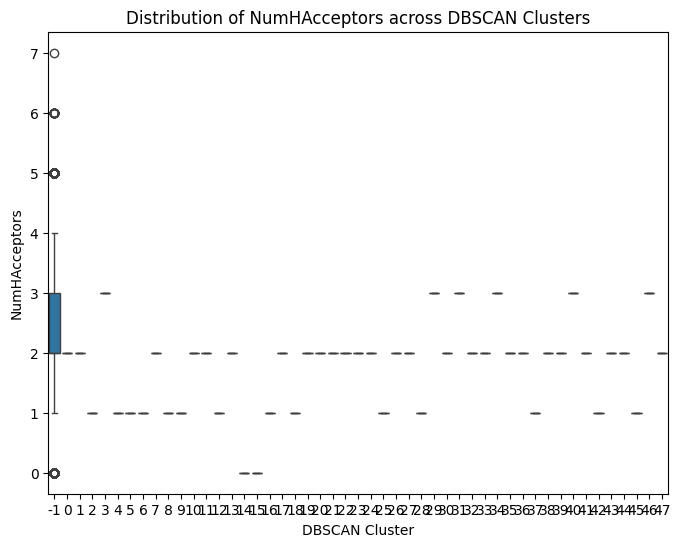

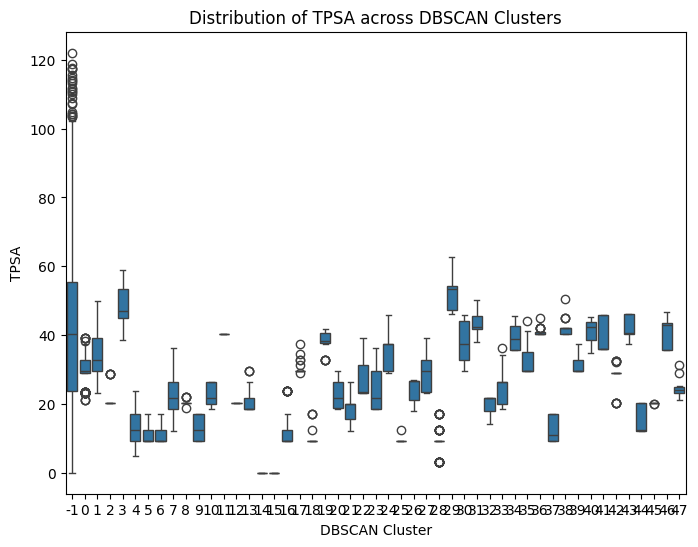

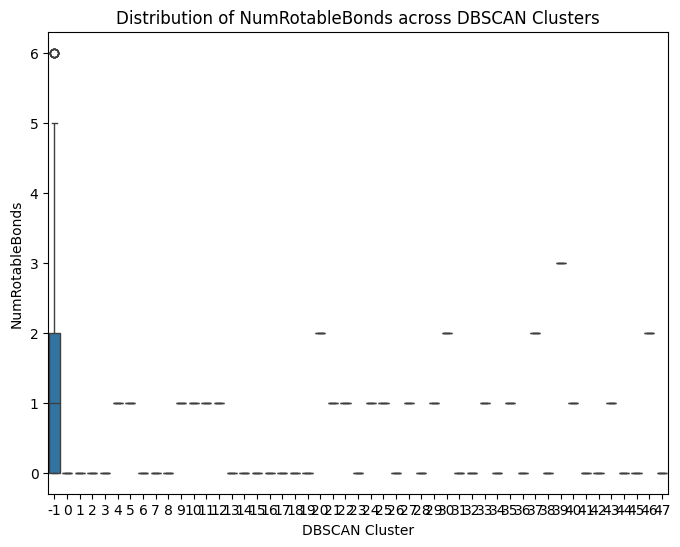

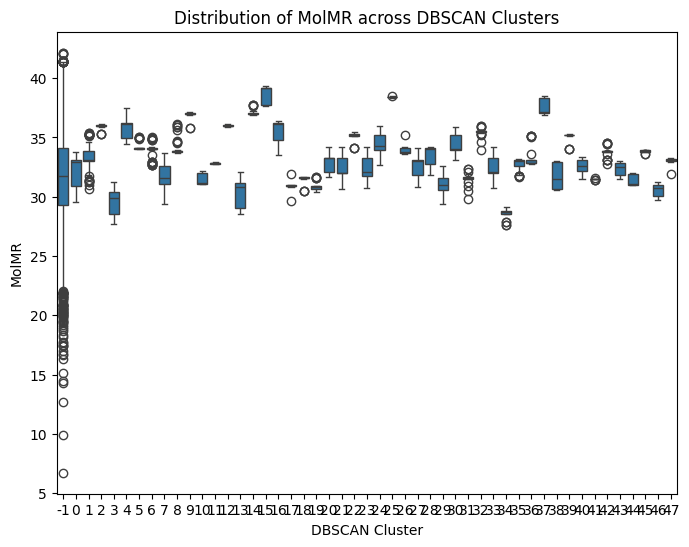

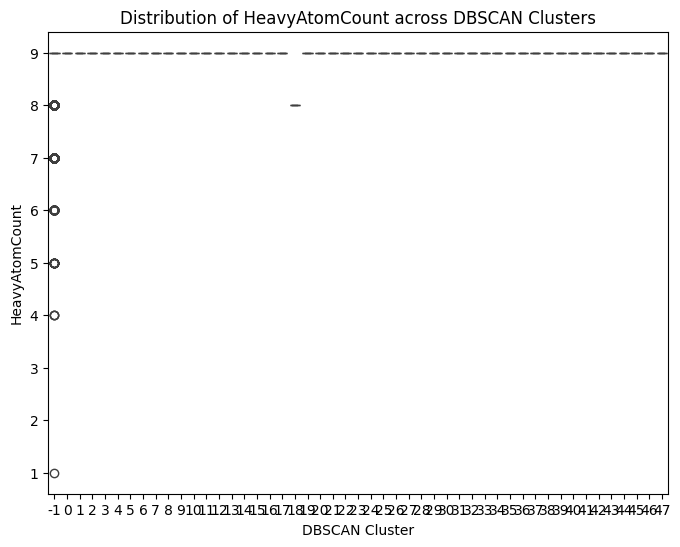

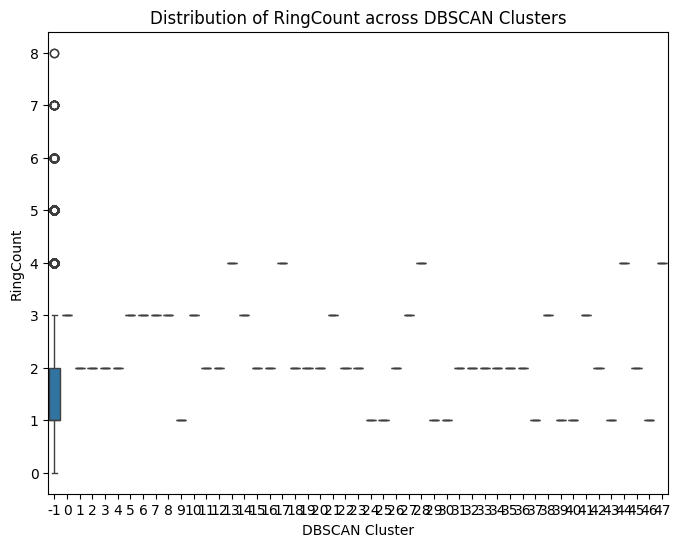

In [ ]:
for descriptor in DESC_LIST:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='dbscan_label', y=descriptor, data=data)
    plt.title(f'Distribution of {descriptor} across DBSCAN Clusters')
    plt.xlabel('DBSCAN Cluster')
    plt.ylabel(descriptor)
    plt.show()

## Summary:

### Data Analysis Key Findings

*   The K-Means and DBSCAN cluster labels were successfully added to the dataset.
*   Box plots visualizing the distribution of each descriptor across both K-Means and DBSCAN clusters (including the DBSCAN noise cluster -1) were generated.

### Insights or Next Steps

*   Analyze the generated plots to qualitatively compare how well each clustering method separated the data based on the selected molecular descriptors.
*   Consider quantitative methods (e.g., ANOVA) to assess the statistical significance of the differences in descriptor distributions between clusters for both K-Means and DBSCAN.
